## Plot squared Pearson R$^2$ and Nash-Sutcliffe efficiency NSE


Both measures (R2) and NSE are indications of how well the observed data fits the simulated one. 

$$NSE= 1-  \frac{\sum \limits_{i=1}^{n} (Y^{obs}_i -Y^{sim}_i )^2}{\sum \limits_{i=1}^{n}(Y^{obs}_i -Y^{mean}_i )^2}  $$

In [55]:
#Import 
%matplotlib notebook
import pandas as pd
import matplotlib.colors as colors
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from functions import mapplot
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from shapely.geometry import Point, MultiPolygon, Polygon, GeometryCollection,mapping
from shapely import ops
from joypy import joyplot
import rasterio
from rasterio.plot import show
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from scipy import stats
import rasterio.mask


In [44]:
#Load error files
folder = Path("D:/Data/students/mariana/codes/GW_forecasting_ML/climmodel/")
df = pd.concat([
    pd.read_csv(fname)
    for fname in folder.glob("summary_CNN_*.txt")
])

In [45]:
len(df)

505

In [46]:
df.loc[df.NSE<0, 'NSE'] = 0

In [47]:
df.r2.describe()

count    505.000000
mean       0.467645
std        0.172028
min        0.001032
25%        0.366403
50%        0.497389
75%        0.607809
max        0.793351
Name: r2, dtype: float64

In [48]:
df.NSE.describe()

count    505.000000
mean       0.313966
std        0.197402
min        0.000000
25%        0.148996
50%        0.322491
75%        0.454395
max        0.774666
Name: NSE, dtype: float64

<IPython.core.display.Javascript object>


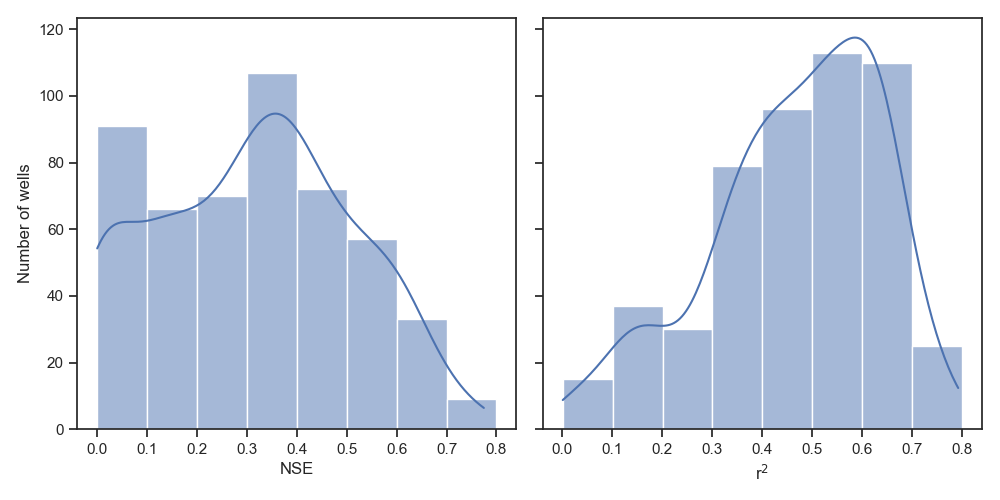

In [49]:

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5), sharey=True)
sns.set_theme(style="dark", palette="deep")
#sns.histplot(data=df.NSE[:len(df_norh)],kde=True)
sp= sns.histplot(data=df['NSE'][:],kde=True,binwidth=0.1, ax=ax1)

ax1.set_xlabel('NSE')
ax1.set_ylabel(r'Number of wells')
#legendax1 = ax1.get_legend()
#handlesax1 = legendax1.legendHandles
#legendax1.remove()
#ax1.legend(handlesax1, ['P, T'],fontsize=3,prop={'size': 8}, loc=2)

sp2=sns.histplot(data=df['r2'][:],kde=True,binwidth=0.1, ax=ax2)
ax2.set_xlabel('r$^2$')
ax2.set_ylabel(r'Number of wells')
#legendax2 = ax2.get_legend( )
#handlesax2 = legendax2.legendHandles
#legendax2.remove()
#ax2.legend(handlesax2,['P, T'],prop={'size': 8}, loc=2)
plt.tight_layout() 

<IPython.core.display.Javascript object>


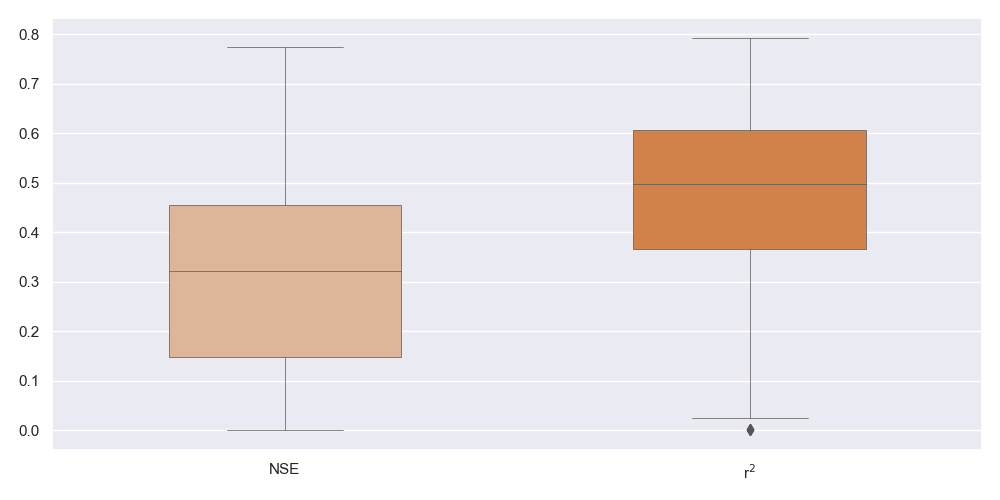

In [50]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,5))
colors = ['#E8B38F', '#e77d34', '#88aed6','#2d77c6']
bx=sns.boxplot(ax=ax,data=df[['NSE','r2']][:],palette=colors,linewidth=0.5,width=0.5)
ax.set_xticklabels(["NSE","r$^2$"])
plt.tight_layout()

## Geospatial analyses

This section is to check the spatial relations between the model performance results and the spatial features such as landcover,  and distance to rivers

In [15]:
#this lines takes a while for running due to the size of the landuse shapefile

#Load shapefiles
gw_sel=gpd.read_file("D:/Data/students/mariana/data/SHP/GWF2.shp")

#LS GIS information OSM
waterbodies=gpd.read_file("D:/Data/students/mariana/data/SHP/waterbodiesND.shp")
waterways=gpd.read_file("D:/Data/students/mariana/data/SHP/waterwaysND.shp")

#Administrative boundaries
germany_states = gpd.read_file("D:/Data/students/mariana/data/SHP/DEU_adm1.shp")
ND=germany_states[germany_states.NAME_1== "Niedersachsen"]

In [16]:
#BGR hydrogeology map 1:250k clipped for Lower Saxony
hydrogeologischeND=gpd.read_file("D:/Data/students/mariana/data/SHP/hydrogeologischeND.shp")

#LS GIS information OSM
citiesND=gpd.read_file("D:/Data/students/mariana/data/SHP/citiesND.shp")
landuse=gpd.read_file("D:/Data/students/mariana/data/SHP/LS/gis_osm_landuse_a_free_1.shp")
places=gpd.read_file("D:/Data/students/mariana/data/SHP/LS/gis_osm_places_a_free_1.shp")

First, the model performance should be associated with the shapefile information

In [51]:
#Create a column to store the accuracy of the models- this is created in the shapefile that has the wells ID
gw_sel[['NSE','r2']]=np.nan
for i in range(len(df)):
    index=gw_sel.loc[gw_sel.MEST_ID==df.wellid.values[i]].index[0]
    gw_sel.at[index, 'NSE'] = df.NSE.values[i]
    gw_sel.at[index, 'r2'] = df.r2.values[i]
    

In [19]:
c=gw_sel.NSE.copy()
c.dropna(inplace=True)
c.describe()

count    424.000000
mean       0.324258
std        0.197667
min        0.000000
25%        0.169513
50%        0.335272
75%        0.471932
max        0.774666
Name: NSE, dtype: float64

### Plot NSE and R2

In [52]:
#Project shapefiles for mapping
proj_coor=4647
gw_sel=gw_sel.to_crs(epsg=proj_coor)
waterbodies=waterbodies.to_crs(epsg=proj_coor)
waterways=waterways.to_crs(epsg=proj_coor)

hydrogeo=hydrogeologischeND.to_crs(epsg=proj_coor)
cities=citiesND.to_crs(epsg=proj_coor)
land_use=landuse.to_crs(epsg=proj_coor)
germany_states=germany_states.to_crs(epsg=proj_coor)
ND=ND.to_crs(epsg=proj_coor)

waterworks_points=gpd.read_file("D:/Data/students/mariana/data/SHP/waterworks/wasserwerk_point.shp")
waterworks_lines=gpd.read_file("D:/Data/students/mariana/data/SHP/waterworks/wasserwerk_line.shp")
waterworks_polys=gpd.read_file("D:/Data/students/mariana/data/SHP/waterworks/wasserwerk_pol.shp")
waterworks_point=waterworks_points.to_crs(epsg=proj_coor)
waterworks_line=waterworks_lines.to_crs(epsg=proj_coor)
waterworks_poly=waterworks_polys.to_crs(epsg=proj_coor)

<IPython.core.display.Javascript object>


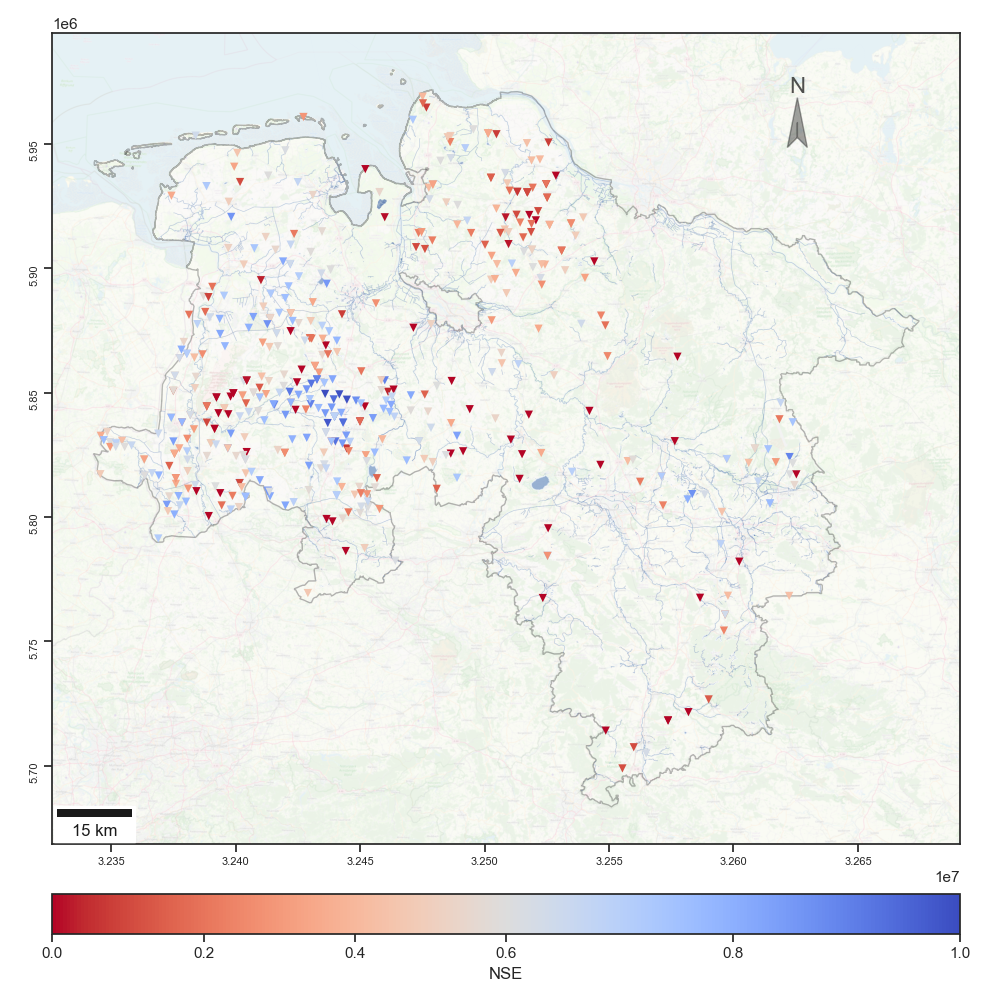

In [56]:
sns.set_theme(style="ticks")
column='NSE'
bound=germany_states.to_crs(gw_sel.crs.to_string()) 
gw=gw_sel.plot(figsize=(10, 10),column=column, markersize=35,
               marker="v", facecolor="None",cmap="coolwarm_r",edgecolor="grey",linewidth=0.01, zorder=3)
wb=waterbodies.plot( ax=gw, alpha=0.5, color='b', linewidth=0.8, zorder=1)
ww=waterways.plot( ax=gw, alpha=0.3, color='b', linewidth=.5,zorder=2)
#wworksp=waterworks_point.plot( ax=gw, color='purple', markersize=15,zorder=2)
#wworkspol=waterworks_poly.plot( ax=gw, color='purple', linewidth=1,zorder=2)
#wworksln=waterworks_line.plot( ax=gw, color='purple', linewidth=1,zorder=2)
#gdff=gdf.plot( ax=gw, alpha=0.5, color='r',markersize=12,zorder=2)
#cit=cities.plot( ax=gw, alpha=0.5, color='r',markersize=40,zorder=2)
NS=ND.boundary.plot( ax=gw, alpha=0.3, edgecolor='k', linewidth=1, zorder=1)

#Colorbar 
sm = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=colors.TwoSlopeNorm(vmin=0, vcenter=0.6, vmax=1))
#sm = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=plt.Normalize(vmin=gw_sel[column].min(), 
#                                                                       vmax=gw_sel[column].max()))

fig=gw.get_figure()
divider = make_axes_locatable(gw)
cax = divider.append_axes('bottom', size='5%', pad=0.5)
cbar = fig.colorbar(sm,orientation="horizontal",fraction=0.05,cax=cax)
if column =='r2':
    cbar.ax.set_xlabel('r$^2$')
else:
    cbar.ax.set_xlabel(column)


#for x, y, label in zip(gw_sel.geometry.x[:len(df)], gw_sel.geometry.y[:len(df)], gw_sel.MEST_ID[:len(df)]):
#    gw.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=5)



#scalebar
scalebar = ScaleBar(0.5, "m", dimension="si-length", length_fraction=0.10, location="lower left")
gw.add_artist(scalebar)
gw.tick_params(axis='y', which='major', labelsize=8, rotation=90)
gw.tick_params(axis='x', which='major', labelsize=8, rotation=0)
startx, endx = gw.get_xlim()
starty, endy = gw.get_ylim()

#North arrow
arrx=endx- endx*0.002
arry=endy-endy*0.0040
gw.text(x=arrx-arrx*0.0001, y=arry, s='N', fontsize=16,alpha=0.8)
gw.arrow(arrx, arry-arry*0.002, 0, 10000, length_includes_head=True,
          head_width=8000, head_length=20000, overhang=.2, ec="k",facecolor='k', alpha=0.4)

#Basemap
#cx.providers.OpenStreetMap.Mapnik
cx.add_basemap(ax=NS,  crs=ND.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik,alpha=0.3,zoom=10,attribution=False,zorder=0)
plt.tight_layout()       

## 1. Depth to groundwater 

In [29]:
#Load additional information of GWL observations
root='D:/Data/students/mariana/data/Grundwasserstandsdaten/'
basisdaten=pd.read_csv(root+'PROJEKT_BASISDATEN.txt', sep=';')
#monatswert=pd.read_csv(root+'PROJEKT_MONATSWERTE.txt', sep=';')

basisdatenc=basisdaten.set_index(basisdaten.MEST_ID)
gw_selc= gw_sel.set_index(gw_sel.MEST_ID)
#Join gw_sel with the additional information contained in basisdaten file
gw_seladd=gw_selc.join(basisdatenc, lsuffix='', rsuffix='_2') 

In [30]:

gw_seladd['FOK2']=gw_seladd['FOK'].apply(lambda x: x.replace(',','.')).astype(float)
gw_seladd['GOK_NN2']=gw_seladd['GOK_NN'].apply(lambda x: x.replace(',','.')).astype(float)
gw_seladd['MBP_NN2']=gw_seladd['MBP_NN'].apply(lambda x: x.replace(',','.')).astype(float)
gw_seladd['MBP-GOK']=gw_seladd['MBP_NN2'] - gw_seladd['GOK_NN2']

<IPython.core.display.Javascript object>


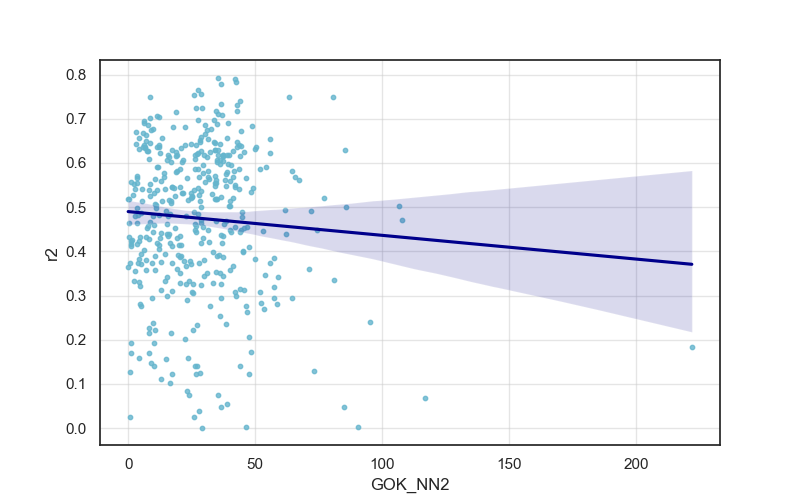

nan nan nan nan nan


In [31]:
sns.set_theme(style="white")

fig, ax = plt.subplots(figsize=(8,5))
dfaux=gw_seladd.sort_values(by="GOK_NN2")
slope, intercept, r_value, p_value, std_err = stats.linregress(dfaux["GOK_NN2"],
                                                               dfaux["r2"])
print(slope, intercept, r_value, p_value, std_err )
cp=sns.regplot(ax=ax,x="GOK_NN2", y="r2", data=dfaux[:],  fit_reg=True, order=1,
 color='darkblue',scatter_kws={"s": 10,"color": "c"}, line_kws={'label':"r$^2$={0:.1f} p-values:{1:.1f}".format(r_value,p_value)})

ax.grid(alpha=0.5)

<IPython.core.display.Javascript object>


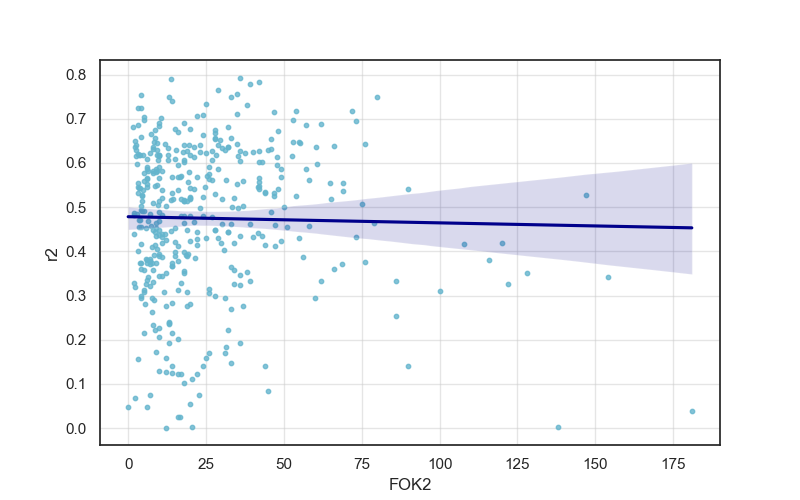

nan


In [33]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(8,5))
dfaux=gw_seladd.sort_values(by="FOK2")[:]
slope, intercept, r_value, p_value, std_err = stats.linregress(dfaux['FOK2'],
                                                               dfaux["r2"])
print(r_value)
cp=sns.regplot(ax=ax,x="FOK2", y="r2", data=dfaux[:], fit_reg=True, order=1,
 color='darkblue',scatter_kws={"s": 10,"color": "c"})
#cp=sns.regplot(ax=ax,x="GOK_NN2", y="r2", data=gw_seladd.sort_values(by="GOK_NN2"), fit_reg=True, order=2,
#               ci=False, color='darkblue',scatter_kws={"s": 10,"color": "c"})
ax.grid(alpha=0.5)

plt.savefig('D:/Data/students/mariana/Documents/Figures/Spatial_relations/FOK_r2_2.png',bbox_inches='tight')

In [312]:
# Add time series to the main dataframe
gw_sel['GOK_NN']=gw_seladd['GOK_NN2'].values
gw_sel['FOK']=gw_seladd['FOK2'].values

## 2. Intersection with the OSM data 

The OpenStreetMap data for the lower Saxony can be obtained in the following link: https://download.geofabrik.de/europe/germany/niedersachsen.html

In [61]:
r=gpd.overlay(gw_sel, land_use, how='intersection')

In [62]:
cl=pd.DataFrame(r.fclass.value_counts())
cl['names']=cl.index
cl.names.replace('nature_reserve','Reserve', inplace=True)
order=cl.names[:]

<IPython.core.display.Javascript object>


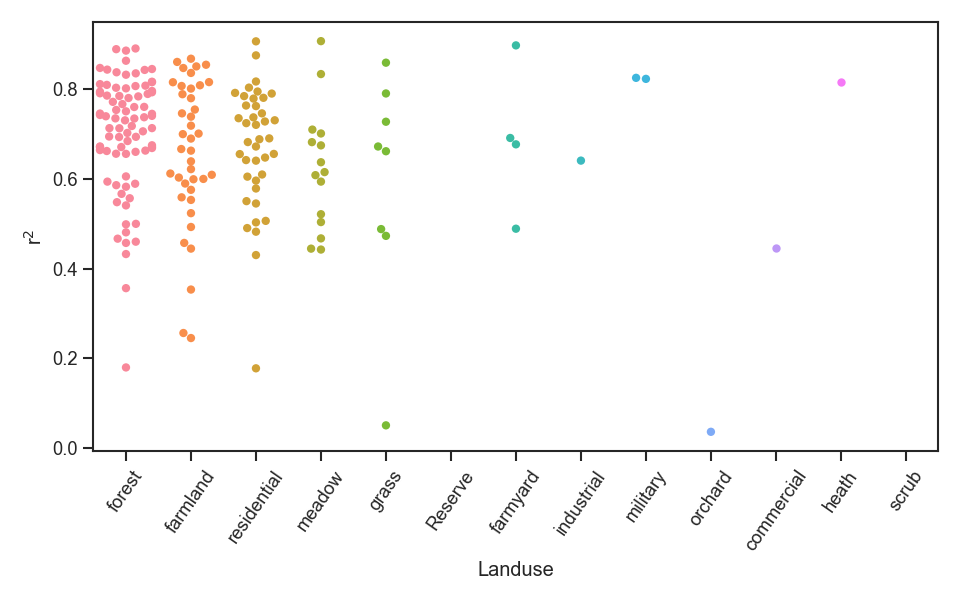

E:\condaenvs\mgo\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [38]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.swarmplot(ax=ax,x="fclass", y="r2",order=order, data=rdrop)
cp.set_xticklabels(order, rotation=55)
ax.set_xlabel('Landuse')
ax.set_ylabel('r$^2$')
plt.tight_layout() 

In [45]:
rdropsel=rdrop.loc[rdrop['fclass'].isin(['forest','farmland','residential','meadow','grass','farmyard'])]

In [48]:
cl='fclass'
rdropselcl=pd.DataFrame(rdropsel[cl].value_counts())
order=rdropselcl.index

<IPython.core.display.Javascript object>


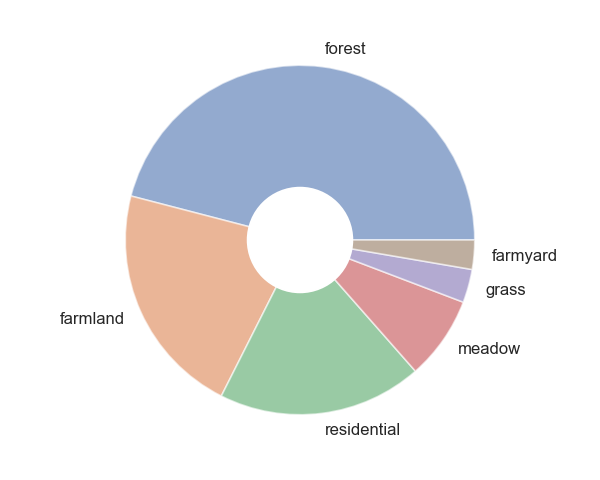

In [55]:

my_circle = plt.Circle( (0,0), 0.3, color='white')
palette = sns.color_palette(None, len(rdropselcl))
plt.figure(figsize=(5,4))
explode=np.zeros(len(rdropselcl))
piep=plt.pie(rdropselcl[cl].values,explode=explode, labels=rdropselcl[cl].index, colors=palette,wedgeprops={'alpha':0.6},textprops={'size': 10})
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.tight_layout()  

<IPython.core.display.Javascript object>


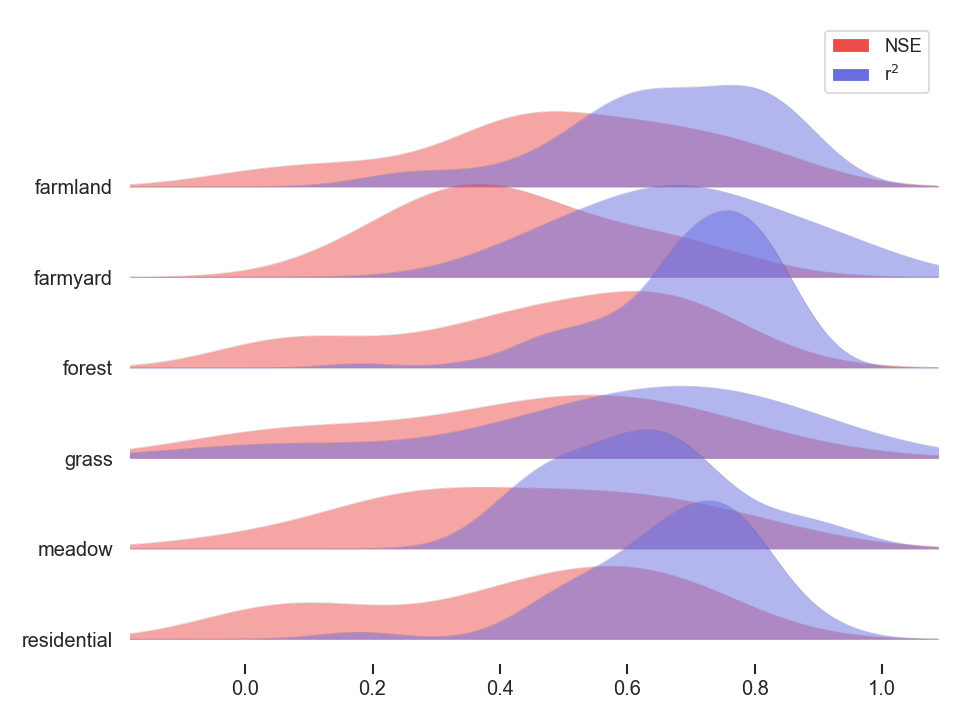

(<Figure size 800x600 with 7 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>])

In [60]:
rdropsel2=rdropsel.rename(columns={"r2": "r$^2$"})
joyplot(
    data=rdropsel2[['NSE',"r$^2$", 'fclass']], 
    by='fclass',
    color=[ '#eb4d4b','#686de0'],
    lw=0.1,
    alpha=0.5,
    legend=True,
    figsize=(8, 6),
)

## 2.1. Waterworks OSM

In [313]:
#Load the corine land cover 2008 
waterworks_points=gpd.read_file("D:/Data/students/mariana/data/SHP/waterworks/wasserwerk_point.shp")
waterworks_lines=gpd.read_file("D:/Data/students/mariana/data/SHP/waterworks/wasserwerk_line.shp")
waterworks_polys=gpd.read_file("D:/Data/students/mariana/data/SHP/waterworks/wasserwerk_pol.shp")
waterworks_point=waterworks_points.to_crs(epsg=proj_coor)
waterworks_line=waterworks_lines.to_crs(epsg=proj_coor)
waterworks_poly=waterworks_polys.to_crs(epsg=proj_coor)

In [314]:
#points=Point(coastlines.geometry[0].coords[0])
l=[]
for ww in waterworks_point.geometry:
    for i in ww :
        l.append(Point(i))
        
for wwl in waterworks_lines.geometry:
    for i in wwl.coords :
        l.append(Point(i))
        
for wwp in waterworks_polys.geometry:
    map_pol=mapping(wwp)['coordinates']
    for polcoor in map_pol :
        [l.append(Point(coords[1],coords[0])) for coords in polcoor]

        
gdfww=gpd.GeoDataFrame(index=np.arange(len(l)), crs='epsg:'+str(proj_coor), geometry=l)

In [315]:
gw_selc=gw_sel.copy()
gdfs = gpd.GeoDataFrame(geometry=gw_selc.geometry).to_crs("EPSG:"+str(proj_coor))
dmtca=gdfs.geometry.apply(lambda g: gdfww.distance(g))
vdist=[]
for i in range(len(dmtca)):
    vdist.append(min(dmtca[dmtca.columns][i:i+1].values[0])/1000)
gw_sel['dist_pww']=vdist  


<IPython.core.display.Javascript object>


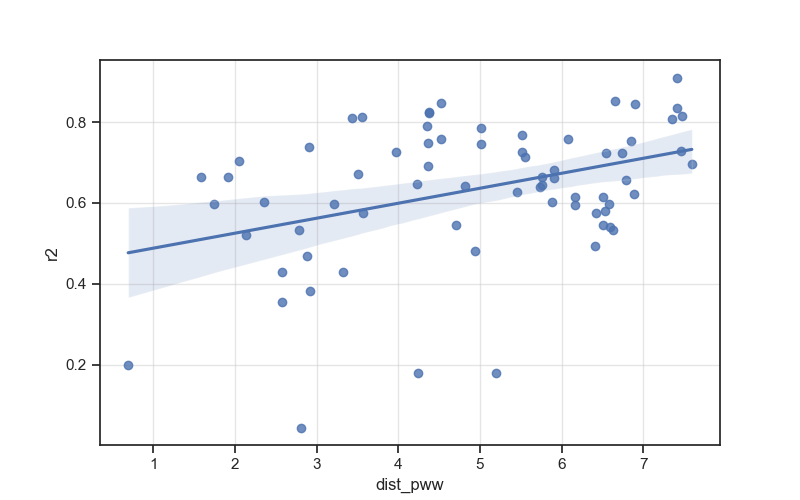

0.38440612573407845


In [385]:
fig, ax = plt.subplots(figsize=(8,5))
data=gw_sel.sort_values(by="dist_pww")[:70]
cp=sns.regplot(ax=ax,x="dist_pww", y="r2", data=data, fit_reg=True)
ax.grid(alpha=0.5)

slope, intercept, r_value, p_value, std_err = stats.linregress(data["dist_pww"],
                                                                   data["r2"])
print(r_value)

## 3. Intersection with Corine-land cover data

Check the relation witht the CORINE Land Cover (CLC) inventory for 2019. 
Downloaded from https://land.copernicus.eu/pan-european/corine-land-cover

It consists of 44 classes described here https://land.copernicus.eu/user-corner/technical-library/corine-land-cover-nomenclature-guidelines/html

'112'--> __Discontinuous urban fabric (Artificial Surfaces )__\
'121'--> Industrial or commercial units (Artificial Surfaces )\
'124'--> Airports (Artificial Surfaces )\
'142'--> Sport and leisure facilities (Artificial Surfaces )\
'211'--> __Non-irrigated arable land (Agricultural areas )__\
'231'--> __Pastures (Agricultural areas )__\
'311'--> Broad-leaved forest (Forest and seminatural areas )\
'312'--> __Coniferous forest  (Forest and seminatural areas )__\
'313'--> Mixed forest (Forest and seminatural areas )\
'322'--> Moors and heathland  (Forest and seminatural areas )\
'412'--> Peatbogs (Wetlands)\
'512'--> Water bodies 

note: the bold categories are the most relevant 

In [317]:
#Load the corine land cover 2008 
clc=gpd.read_file("D:/Data/students/mariana/data/SHP/clc2018/clc2018_LSr.shp")
clcs=clc.to_crs(epsg=proj_coor)

In [318]:
#Intersect the layer and the wells ID
clcsint=gpd.overlay(gw_sel, clcs, how='intersection')

In [319]:
dic_cat={'112':'Discontinuous urban fabric',
'121': 'Industrial or commercial units ',
'124' : 'Airports',
'142': 'Sport and leisure facilities',
'211': 'Non-irrigated arable land' ,
'231': 'Pastures',
'311' : 'Broad-leaved forest', 
'312': 'Coniferous forest' , 
'313': 'Mixed forest' ,
'322': 'Moors and heathland' , 
'412': 'Peatbogs' ,
'512':' Water bodies' }

#Map dictionary into a new column to recognize which code corresponds to which definition
clcsint['name']=clcsint['Code_18'].map(dic_cat)
clcs['name']=clcs['Code_18'].map(dic_cat)

In [320]:
cl='name'
clcsintcl=pd.DataFrame(clcsint[cl].value_counts())
order=clcsintcl.index

In [321]:
Lcat=clcsintcl.loc[clcsintcl.name<8].index
ind=clcsint.loc[clcsint['name'].isin(Lcat)].name.index
clcsint.loc[ind, 'name'] = "others"

In [338]:
#cl='name'
#clcsintcl=pd.DataFrame(clcsint[cl].value_counts())
#order=clcsintcl.index
#palette = sns.color_palette(None, len(rdropselcl))
#plt.figure(figsize=(5,5))
#my_circle = plt.Circle( (0,0), 0.3, color='white')
#colors = ['chocolate','#66b3ff','#99ff99','#ffcc99','c','olive']
#plt.pie(clcsintcl[cl].values, labels=clcsintcl[cl].index, colors=palette,wedgeprops={'alpha':0.5})
#p = plt.gcf()
#p.gca().add_artist(my_circle)
#plt.tight_layout()  

In [76]:
col='Code_18'
clcclass=pd.DataFrame(clcsint[col].value_counts())
order=clcclass.index
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.swarmplot(ax=ax,x=col, y="NSE",order=order, data=clcsint)
cp.set_xticklabels(order, rotation=55)
ax.set_xlabel(col)
ax.set_ylabel('NSE')
plt.tight_layout() 

<IPython.core.display.Javascript object>

In [340]:
col='name'
clcclass=pd.DataFrame(clcsint[col].value_counts())
order=clcclass.index
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.swarmplot(ax=ax,x=col, y="NSE",order=order, data=clcsint)
cp.set_xticklabels(order, rotation=55)
ax.set_xlabel(col)
ax.set_ylabel('NSE')
plt.tight_layout() 

<IPython.core.display.Javascript object>

In [341]:
dic=clcclass.name.to_dict()
clcsint['name_sor']=clcsint.name.map(dic)
clcsint_sort=clcsint.sort_values(by='name_sor',ascending=False)

In [342]:
clcsint_sort1=clcsint_sort.loc[clcsint_sort.name!="others"]

In [343]:
clcsint_sort2=clcsint_sort1.rename(columns={"r2": "r$^2$"})

In [344]:
col='name'
joyplot(
    data=clcsint_sort2[['NSE',"r$^2$", col]], 
    by=col,
    color=[ '#eb4d4b','#686de0'],
    lw=0.1,
    alpha=0.5,
    legend=True,
    figsize=(8, 6)
)

<IPython.core.display.Javascript object>

(<Figure size 800x600 with 6 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>])

### 3.1. Intersection with 4 km buffer
Inntersect buffer with the shape of corine land covers.

In [422]:
clcsint['buffer']=clcsint.buffer(4000)
gw_sel['buff_1km']=gw_sel.buffer(1000)
gw_sel['buff_3km']=gw_sel.buffer(3000)
gw_sel['buff_4km']=gw_sel.buffer(4000)
gw_sel['buff_5km']=gw_sel.buffer(3000)
#b=clcsint.buffer(1000)
#b.to_file('D:/Data/students/mariana/data/test.shp')  

In [326]:
#clcs is the shapefile of corine land cover
rectangles=clcs.geometry[:]
names_dic=clcs.name
wellid=clcsint.MEST_ID # To make sure the well id corresoinds with the buffer at all time
names=clcs.Code_18
dfs, wids=[] , []

count=0
for c in clcsint['buffer'].geometry:
   
    vnames, vnamesdic, geotypes, geoms, parea=[] , [], [] ,[] ,[]

    for r, nm, nmdic in zip(rectangles,names,names_dic):
        # create intersection 
        inters=c.intersection(r)
        #Check geometry type
        geoms.append(inters)
        #Store the names of the land covers to associate with every geometry
        vnames.append(nm)
        vnamesdic.append(nmdic)
        geotypes.append(inters.geom_type)

    # create shapely GeometryCollection
    geom_collection = GeometryCollection(geoms)

    pols, vnams, vnamsdic=[], [], []
    for i,vn, vndic, gt in zip(geom_collection, vnames,vnamesdic, geotypes):
        if gt == 'Polygon':
            poly=Polygon(i)
        else:
            poly=MultiPolygon(i) 

        if not poly.is_empty:
            pols.append(poly)
            vnams.append(vn)
            vnamsdic.append(vndic)
            parea.append(poly.area/10E6) # add area in km2
    
    
    
    prop=parea/np.sum(parea)
    d = {'col1': vnams, 'names':vnamsdic ,'geometry': pols, 'area':parea, 'prop':prop}
    df = gpd.GeoDataFrame(d, crs="EPSG:4647") #(assign epsg)
    dfs.append(df)
    wids.append(wellid[count])
    count+=1
    #df.to_file('D:/Data/students/mariana/data/test3.shp')

<IPython.core.display.Javascript object>


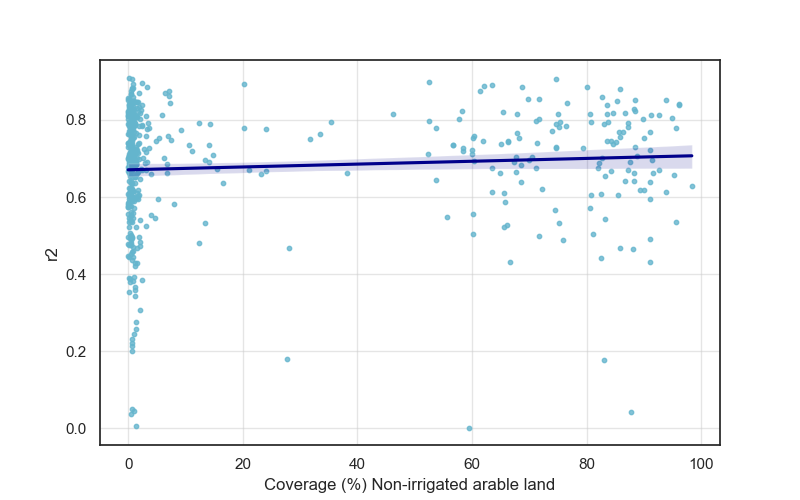

<IPython.core.display.Javascript object>


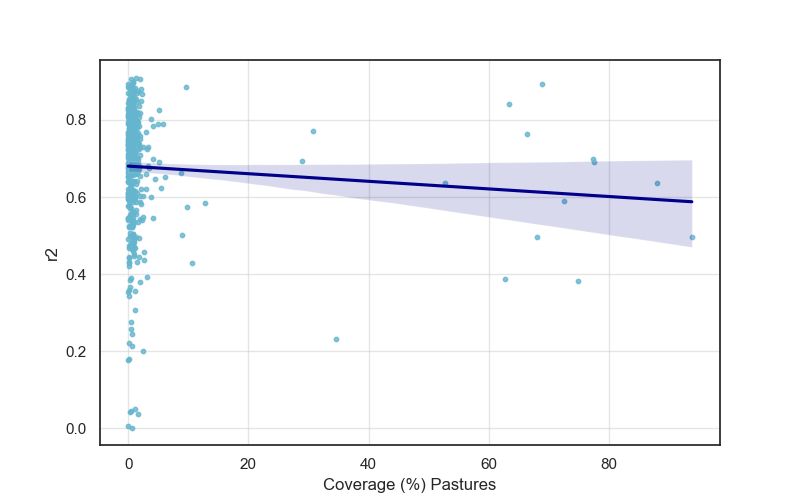

<IPython.core.display.Javascript object>


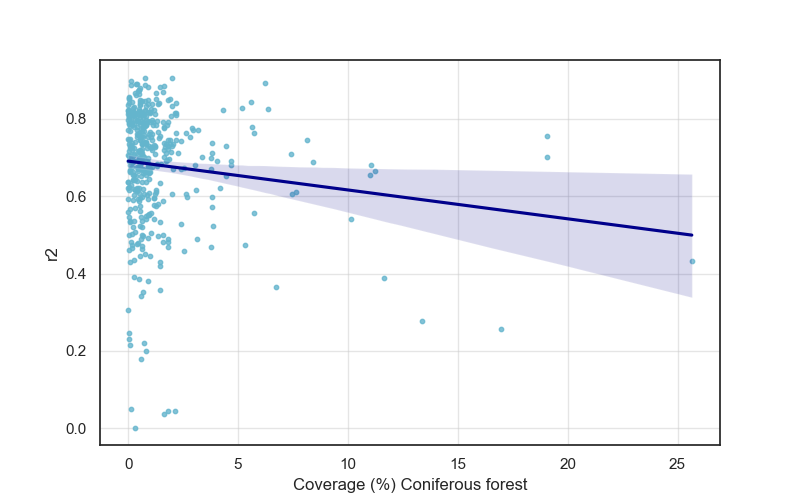

<IPython.core.display.Javascript object>


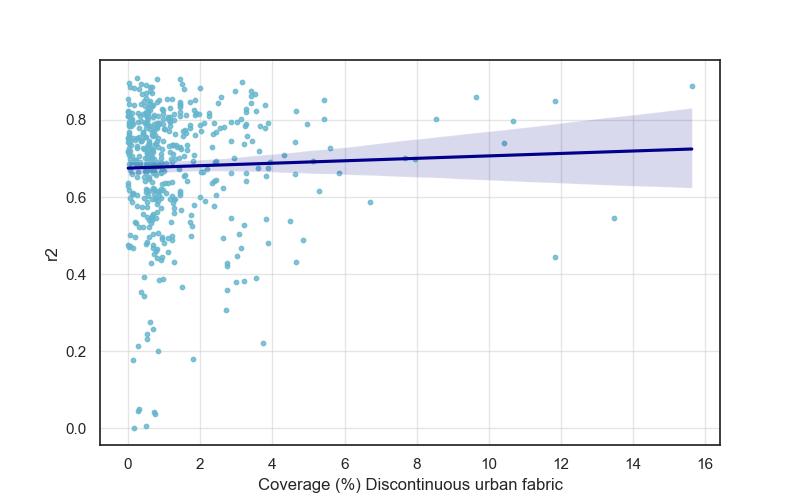

<IPython.core.display.Javascript object>


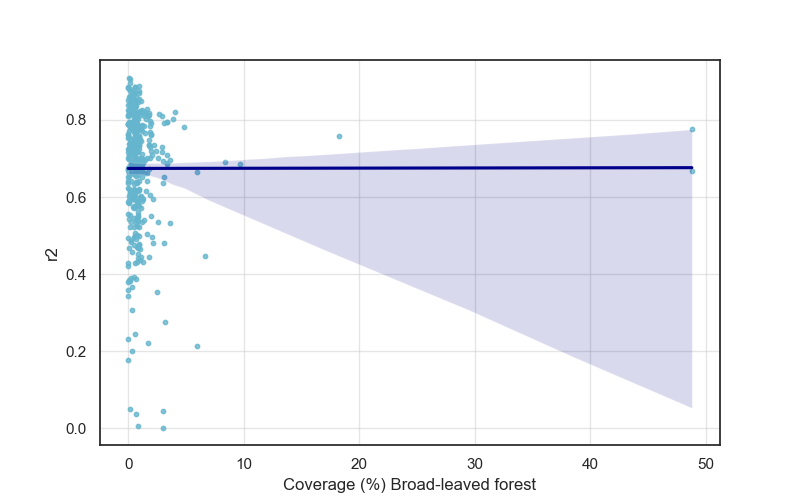

In [327]:

#List of the code for the main categories of clc in the study area
lcod=['211','231','312','112','311']
catname=[ 'Non-irrigated arable land' , 'Pastures','Coniferous forest' , 
         'Discontinuous urban fabric', 'Broad-leaved forest']

for categ, name in zip(lcod,catname):
    li=[]
    for datf in dfs:
        pr=datf[datf.col1==categ].prop
        if not pr.empty:
            li.append(pr.values[0]*100)

        else:
            li.append(0.0)


    #gw_sel['prop_'+categ]=np.zeros(len(gw_sel))
    gw_selaux=gw_sel.loc[gw_sel.MEST_ID.isin(wids)]
    gw_selaux['prop_'+categ]=li
    gw_selaux1=gw_selaux.loc[gw_selaux['r2']>0]
    gw_selaux2=gw_selaux1.loc[gw_selaux1['prop_'+categ]>0]

    selcol=['MEST_ID']+list(gw_selaux.columns[-1:])
    gw_sel=gw_sel.merge(gw_selaux[selcol],how='left',left_on='MEST_ID', right_on='MEST_ID')
    
    
    sns.set_theme(style="white")
    fig, ax = plt.subplots(figsize=(8,5))
    cp=sns.regplot(ax=ax,x='prop_'+categ, y="r2", data=gw_selaux2.sort_values(by='prop_'+categ), fit_reg=True, order=1,
     color='darkblue',scatter_kws={"s": 10,"color": "c"})
    ax.set_xlabel('Coverage (%) '+name)
    #cp=sns.regplot(ax=ax,x="GOK_NN2", y="r2", data=gw_seladd.sort_values(by="GOK_NN2"), fit_reg=True, order=2,
    #               ci=False, color='darkblue',scatter_kws={"s": 10,"color": "c"})
    ax.grid(alpha=0.5)

## 4. Multi-Order Hydrologic Position

Max project-
J:\NUTZER\Noelscher.M\Studierende\Daten\multiorder_hydrologic_position\germany\time_invariant\raster\v013_1_1\data

There are three main products:\
SD: Distance to the stream \
LP: relative position between the stream and the catchment boundary \
DSD: distance to the stream plus distance to the catchment boundary

#### SD - Distance to stream

<IPython.core.display.Javascript object>


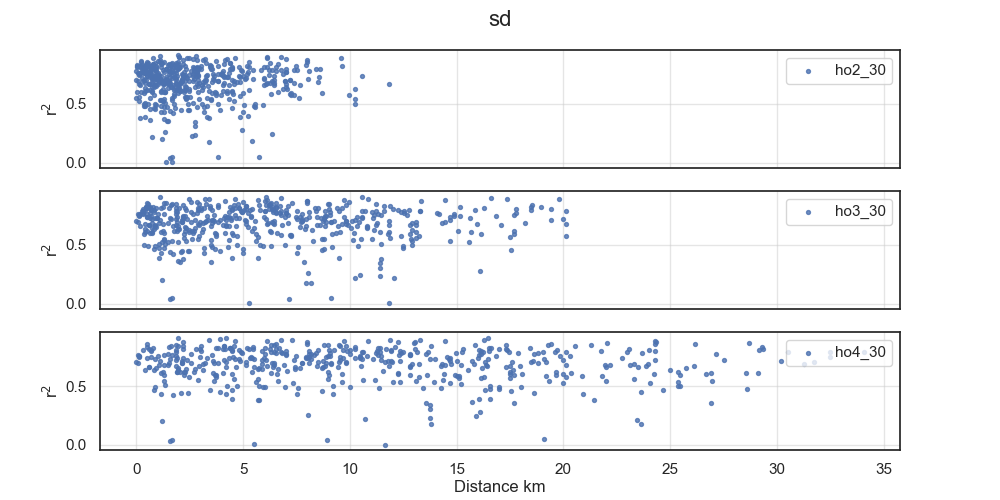

<IPython.core.display.Javascript object>


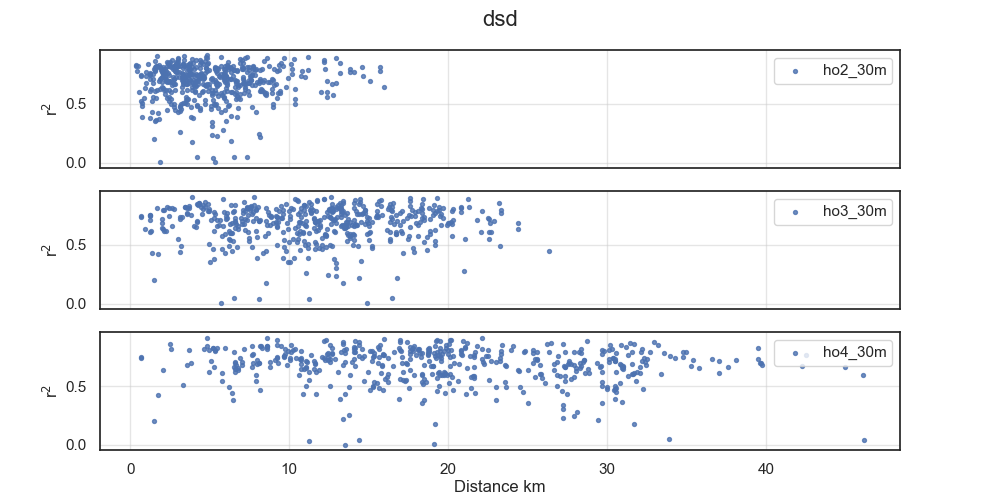

<IPython.core.display.Javascript object>


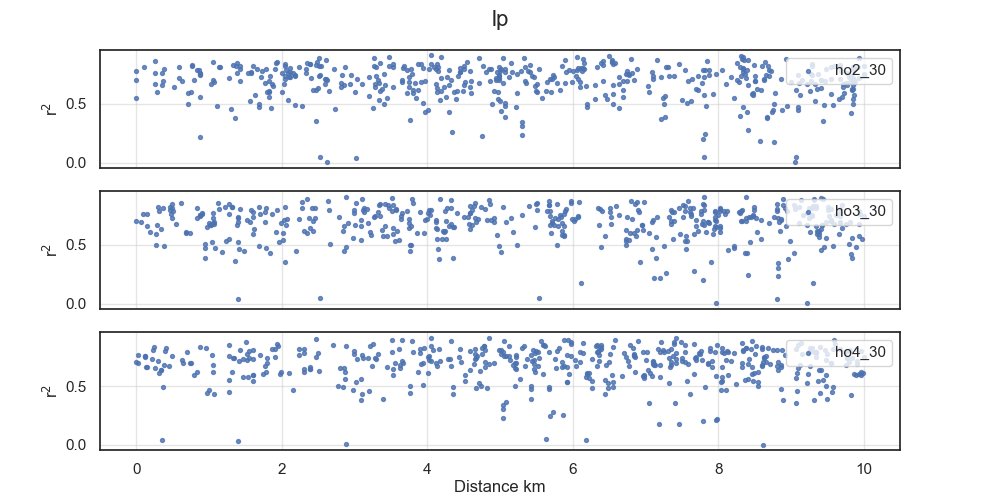

In [328]:
ni=2
ln=np.arange(2,5)

for nm in ['sd','dsd','lp']:
    fig, ax = plt.subplots(len(ln),1, figsize=(10,5),sharex=True)
    for i in ln:
        ho=rasterio.open("D:/Data/students/mariana/data/Raster/multiorder_hydroposition/mohp_custom_germany_"+nm+"_hydrologicorder"+str(i)+"_30m_4647.tif")

        cl="ho"+str(i)+"_30m_"+nm
        measure='r2'
        coord_list = [(x,y) for x,y in zip(gw_sel['geometry'].x , gw_sel['geometry'].y)]
        gw_sel[cl] = [x[0]/1000 for x in ho.sample(coord_list)]

        cp=sns.regplot(ax=ax[i-ni],x=cl, y=measure, data=gw_sel.sort_values(by=cl), fit_reg=False, label=cl[:-4],
                      scatter_kws={'s':8})
        cp.set(xlabel=None)
        if measure== 'r2':
            ax[i-2].set_ylabel("r$^2$")
        #ax[i-2].set_title(cl)
        ax[i-ni].legend(loc=1)
        ax[i-ni].grid(alpha=0.5)
        fig.supxlabel("Distance km",fontsize=12)
        fig.suptitle(nm, fontsize=16)
        plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.2)


Anlyses per catchment

In [322]:
#Catchments
catchmens=gpd.read_file("D:/Data/students/mariana/data/SHP/catchment.shp")
catchment=catchmens.to_crs(epsg=proj_coor)
gw_selcat=gpd.overlay(gw_sel, catchment, how='intersection')
clname='NAME_2500'
gw_selcatu=pd.DataFrame(gw_selcat[clname].value_counts())
print(gw_selcatu)
gw_selname=gw_selcat[gw_selcat[clname]=='Hase']

       NAME_2500
Ems          133
Hase         104
Elbe          66
Weser         63
Hunte         41
Aller         37
Issel         33
Leine         16
Bode           1


<IPython.core.display.Javascript object>


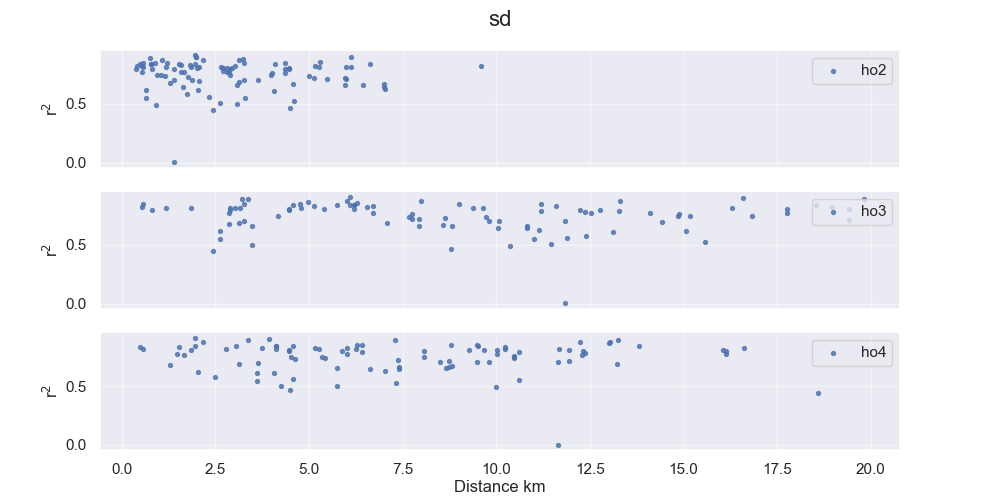

<IPython.core.display.Javascript object>


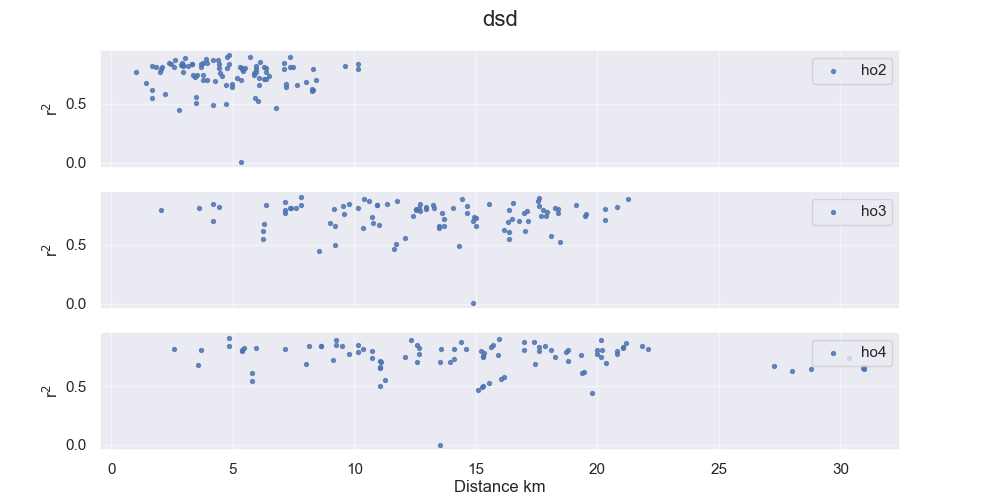

<IPython.core.display.Javascript object>


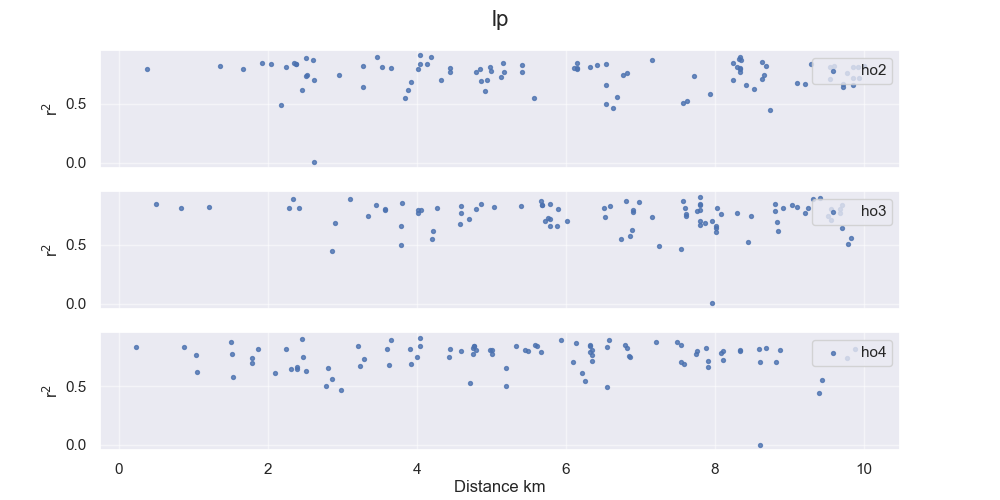

In [323]:
ni=2
ln=np.arange(2,5)

for nm in ['sd','dsd','lp']:
    fig, ax = plt.subplots(len(ln),1, figsize=(10,5),sharex=True)
    for i in ln:
        ho=rasterio.open("D:/Data/students/mariana/data/Raster/multiorder_hydroposition/mohp_custom_germany_"+nm+"_hydrologicorder"+str(i)+"_30m_4647.tif")

        cl="ho"+str(i)+"_30m"
        measure='r2'
        coord_list = [(x,y) for x,y in zip(gw_selname['geometry'].x , gw_selname['geometry'].y)]
        gw_selname[cl] = [x[0]/1000 for x in ho.sample(coord_list)] #values in km

        cp=sns.regplot(ax=ax[i-ni],x=cl, y=measure, data=gw_selname.sort_values(by=cl), fit_reg=False, label=cl[:-4],
                      scatter_kws={'s':8})
        cp.set(xlabel=None)
        if measure== 'r2':
            ax[i-2].set_ylabel("r$^2$")
        ax[i-ni].legend(loc=1)
        ax[i-ni].grid(alpha=0.5)
        fig.supxlabel("Distance km",fontsize=12)
        fig.suptitle(nm, fontsize=16)
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, 
                        wspace=0.4, hspace=0.2)

<IPython.core.display.Javascript object>


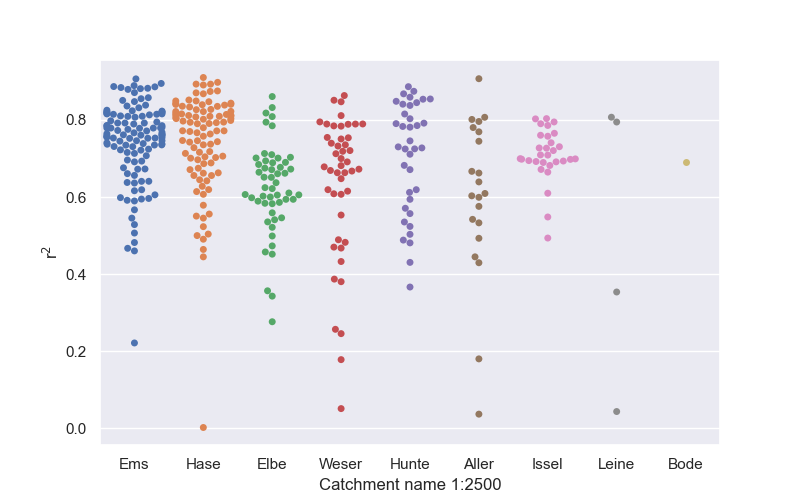

Text(0.5, 0, 'Catchment name 1:2500')

In [332]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.swarmplot(ax=ax,x="NAME_2500", y="r2", data=gw_selcat, order=gw_selcatu.index)
ax.set_ylabel('r$^2$')
ax.set_xlabel('Catchment name 1:2500')

## 5. Distance to the sea

In [329]:
#Load the coastline of Lower Saxony
coastline=gpd.read_file("D:/Data/students/mariana/data/SHP/coastline.shp")
coastlines=coastline.to_crs(epsg=proj_coor)

In [330]:
#points=Point(coastlines.geometry[0].coords[0])
l=[]
for i in waterways.geometry[0].coords:
    l.append(Point(i))
gdf=gpd.GeoDataFrame(index=np.arange(len(l)), crs='epsg:'+str(proj_coor), geometry=l)

In [331]:
gw_selc=gw_sel.copy()

In [332]:
gdfs = gpd.GeoDataFrame(geometry=gw_selc.geometry).to_crs("EPSG:"+str(proj_coor))
dmtca=gdfs.geometry.apply(lambda g: gdf.distance(g))
vdist=[]
for i in range(len(dmtca)):
    vdist.append(min(dmtca[dmtca.columns][i:i+1].values[0])/1000)
gw_sel['dist_coastkm']=vdist  

<IPython.core.display.Javascript object>


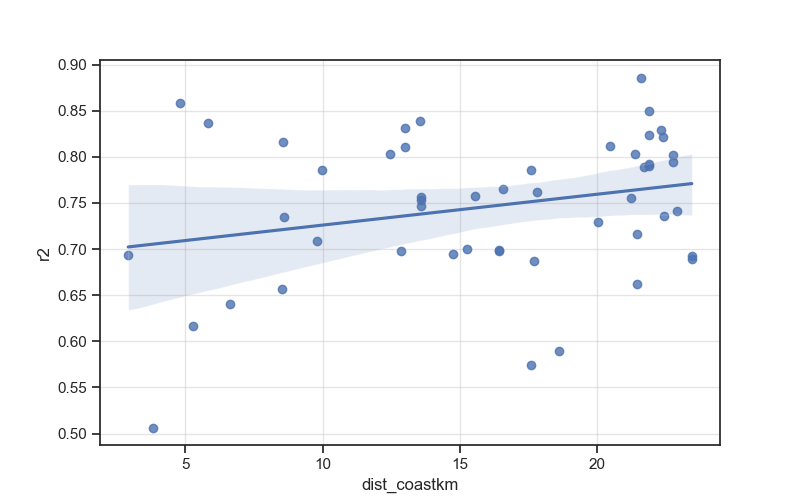

In [375]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x="dist_coastkm", y="r2", data=gw_sel.sort_values(by="dist_coastkm")[:50], fit_reg=True)
ax.grid(alpha=0.5)

## 6. Waterways

In [333]:
#points=Point(coastlines.geometry[0].coords[0])
l2=[]
for j in range(len(waterways.geometry)):
    if waterways.type[j] =='MultiLineString':
        lenmline=len(waterways.geometry[j])
        for ln in range(lenmline):
            l=len(waterways.geometry[j][ln].coords)
            for v in waterways.geometry[j][ln].coords:
                l2.append(Point(v))
    else:
        
        for i in waterways.geometry[j].coords:
                l2.append(Point(i))


#gdf2=gpd.GeoDataFrame(index=np.arange(len(l)), crs='epsg:'+str(proj_coor), geometry=l2)
#gdf2.plot()


<IPython.core.display.Javascript object>


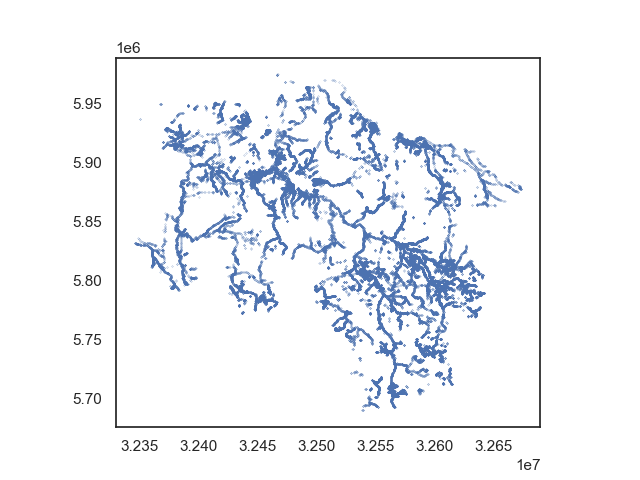

In [334]:
gdf=gpd.GeoDataFrame(index=np.arange(len(l2)), crs='epsg:'+str(proj_coor), geometry=l2)
gdf.plot(markersize=0.03)
gw_selc=gw_sel.copy()

In [335]:
gdfs = gpd.GeoDataFrame(geometry=gw_selc.geometry).to_crs("EPSG:"+str(proj_coor))
dmtca=gdfs.geometry.apply(lambda g: gdf.distance(g))
vdist=[]
for i in range(len(dmtca)):
    vdist.append(min(dmtca[dmtca.columns][i:i+1].values[0])/1000)
gw_sel['dist_water']=vdist  

<IPython.core.display.Javascript object>


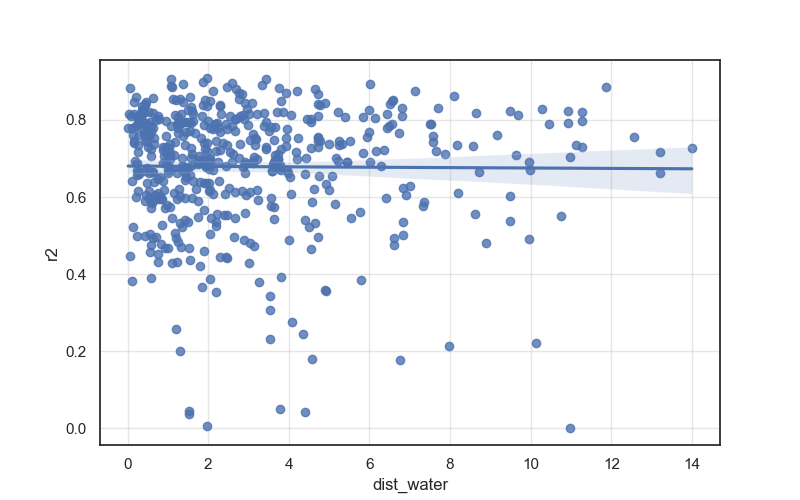

In [403]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x="dist_water", y="r2", data=gw_sel.sort_values(by="dist_water")[:], fit_reg=True)
ax.grid(alpha=0.5)

## 7.  Impervious layer 

Check how much the model performance is affected by the imperviousness density (%)

https://land.copernicus.eu/pan-european/high-resolution-layers/imperviousness/status-maps/2006?tab=mapview


In [337]:
sns.set_theme(style="ticks")
impervious=rasterio.open("D:/Data/students/mariana/data/Raster/Impervious/IMD_2006_100m_eu_03035_d03_E40N30_4647.tif")
#plt.figure(figsize=(3,3))
#show(impervious)

In [338]:
cl="impervious"
coord_list = [(x,y) for x,y in zip(gw_sel['geometry'].x , gw_sel['geometry'].y)]
gw_sel[cl] = [x[0] for x in impervious.sample(coord_list)]


In [241]:
gw_selcop=gw_sel.loc[gw_sel[cl]<5]

<IPython.core.display.Javascript object>


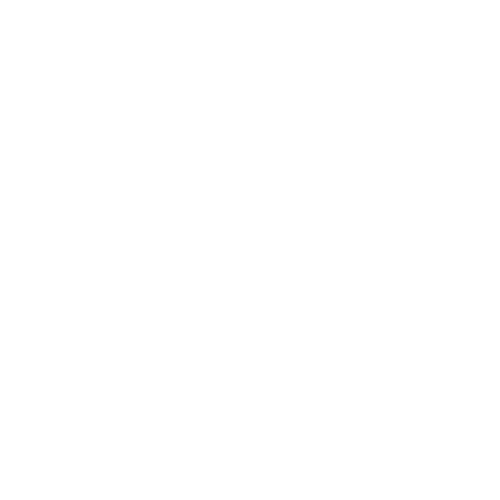

In [242]:
gw_selimp=pd.DataFrame(gw_selcop[cl].value_counts())
order=gw_selimp.index
plt.figure(figsize=(5,5))
my_circle = plt.Circle( (0,0), 0.5, color='white')
colors = ['chocolate','#66b3ff','#99ff99','#ffcc99','c','olive']
plt.pie(gw_selimp[cl].values, labels=gw_selimp[cl].index, colors=colors,wedgeprops={'alpha':0.5})
p = plt.gcf()
p.gca().add_artist(my_circle)

In [243]:
lsel=gw_selimp.impervious[0:5].index.astype(int).sort_values()

In [244]:
lsel.astype(str)

Index(['0', '1', '2', '3', '4'], dtype='object')

<IPython.core.display.Javascript object>


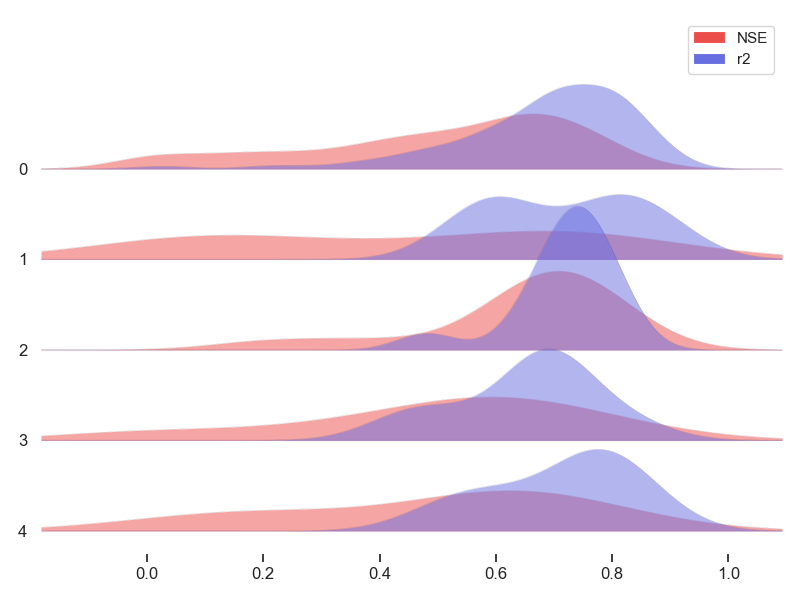

(<Figure size 800x600 with 6 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>])

In [245]:
gw_sel[cl]=gw_sel[cl].astype(str)
gw_selaux=gw_sel[['NSE','r2', cl]].loc[gw_sel[cl].isin(lsel.astype(str))]
joyplot(
    data=gw_selaux[['NSE','r2', cl]], 
    by=cl,
    color=[ '#eb4d4b','#686de0'],
    lw=0.1,
    alpha=0.5,
    legend=True,
    figsize=(8, 6)
)

## 7.1 Impervious layer with '''km buffer

In [42]:
gw_sel['imperv_buff']=np.zeros(len(gw_sel))
for i in range(len(gw_sel)):
    out_mask, out_transform = rasterio.mask.mask(impervious, gw_sel['buff_5km'][i:i+1], crop=True)
    meanval=np.mean(out_mask[out_mask!=impervious.meta['nodata']])
    gw_sel['imperv_buff'][i]=meanval

NameError: name 'impervious' is not defined

In [41]:
meanval

NameError: name 'meanval' is not defined

<IPython.core.display.Javascript object>


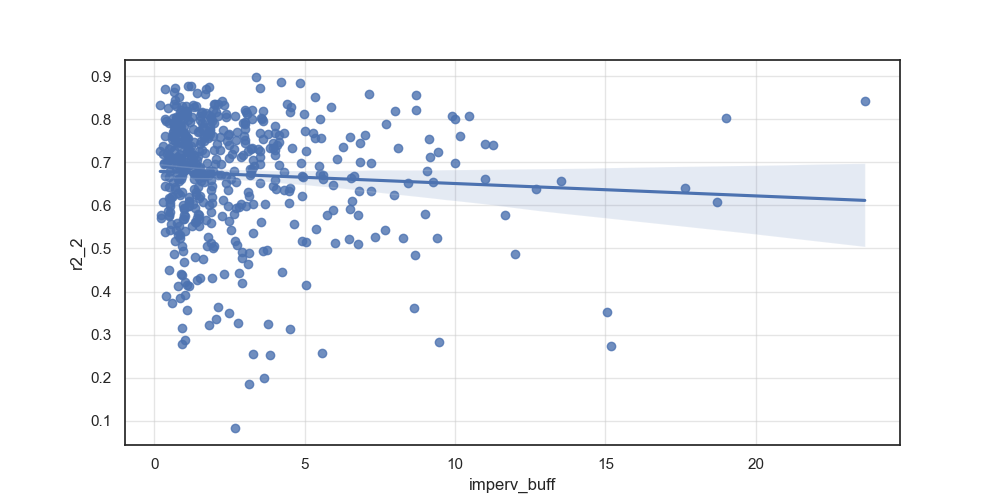

-0.0631722701942286


In [442]:
fig, ax = plt.subplots(figsize=(10,5))
data=gw_sel[gw_sel['imperv_buff']>0].sort_values(by=['imperv_buff'])
cp=sns.regplot(ax=ax,x='imperv_buff', y="r2_2", data=data, fit_reg=True)
plt.grid(alpha=0.5)

slope, intercept, r_value, p_value, std_err = stats.linregress(data["imperv_buff"],
                                                                   data["r2_2"])
print(r_value)

## 8. Geomorphology

Geomorphography from the Bundesanstalt für Geowissenschaften und Rohstoffe (BGR)

In [341]:
sns.set_theme(style="ticks")
geomorphology=rasterio.open("D:/Data/students/mariana/data/Raster/geomorphography/gmk1000_250_4647.tif")
geomorphologyc=rasterio.open("D:/Data/students/mariana/data/Raster/geomorphography/gmk1000_250_4647c.tif")
#geomorphology.plot()
#show(geomorphology)

In [342]:
cl="geomorphology"
coord_list = [(x,y) for x,y in zip(gw_sel['geometry'].x , gw_sel['geometry'].y)]
gw_sel[cl] = [x[0] for x in geomorphology.sample(coord_list)]

1011: very low inclined relief units in very low height above depth contour and high soil moisture index\
1012: low inclined relief units at low altitude  above depth contour and medium soil moisture index\
1021: moderately inclined relief units at medium height  above depth contour and low soil moisture index\
111: Sink areas at very low elevation above  depth contour and with very high soil moisture index\
112: Sink areas at very low elevation above  depth contour and with high soil moisture index\
113: Sink areas at low elevation above depth contour and with high soil moisture index\
114: Sink areas at medium height above depth contour and with medium soil moisture index\
115: Sink areas at medium height above depth contour and with low soil moisture index

In [343]:
dic_geom={1011:'Low Relief/ High-mod SMI',
113: 'Sink areas/ High SMI',
114 : 'Sink areas/ Medium SMI',
112: 'Sink areas/ High SMI',
115: 'Sink areas/ Low SMI' ,
1012: 'Low Relief/ High-mod SMI',
111 : 'Sink areas/ High SMI', 
1021: 'Moderate Relief/ low SMI' , 
3290: 'Others',
3213: 'Others' , 
116: 'Others' ,
3212:'Others',
3211:'Others',
1022:'Others' }

In [344]:
gw_sel["geomorphology_dic"]=gw_sel[cl].map(dic_geom)

<IPython.core.display.Javascript object>


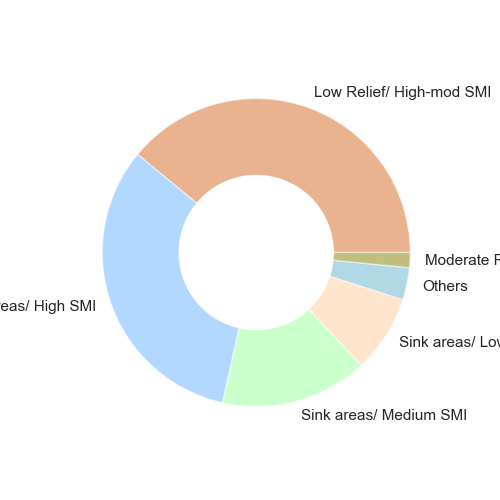

In [345]:
cl='geomorphology_dic'
gw_selgeo=pd.DataFrame(gw_sel[cl].value_counts())
order=gw_selgeo.index
plt.figure(figsize=(5,5))
my_circle = plt.Circle( (0,0), 0.5, color='white')
colors = ['chocolate','#66b3ff','#99ff99','#ffcc99','c','olive']
plt.pie(gw_selgeo[cl].values, labels=gw_selgeo[cl].index, colors=colors,wedgeprops={'alpha':0.5})
p = plt.gcf()
p.gca().add_artist(my_circle)

<IPython.core.display.Javascript object>


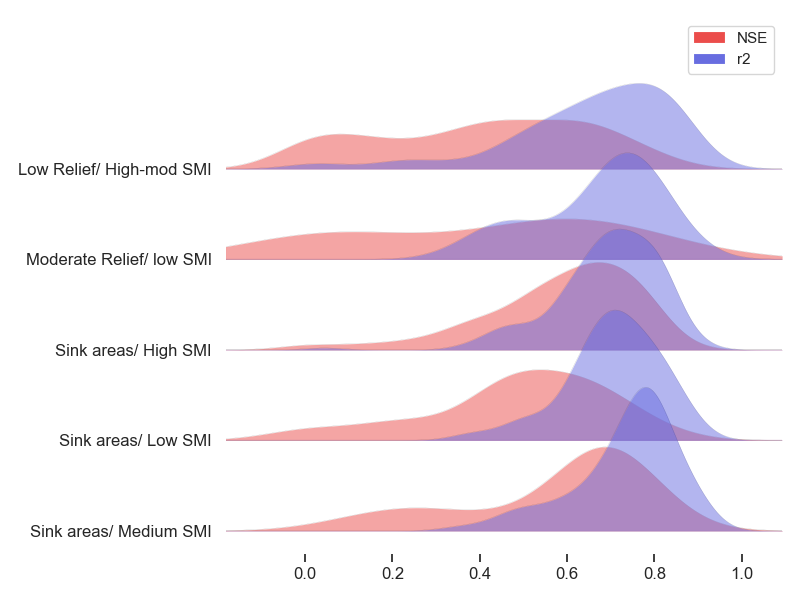

(<Figure size 800x600 with 6 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>])

In [114]:
gw_selaux=gw_sel[['NSE','r2', 'geomorphology_dic']].loc[~gw_sel['geomorphology_dic'].isin(['Others'])]

joyplot(
    data=gw_selaux[['NSE','r2', cl]], 
    by=cl,
    color=[ '#eb4d4b','#686de0'],
    lw=0.1,
    alpha=0.5,
    legend=True,
    figsize=(8, 6)
)

### 8.1 Geomorphology categorical fraction around 1 km buffer

1011:'Low Relief/ High-mod SMI',\
113: 'Sink areas/ High SMI',\
112: 'Sink areas/ High SMI',\
111 : 'Sink areas/ High SMI',\
114 : 'Sink areas/ Medium SMI',\
115: 'Sink areas/ Low SMI' ,\
1012: 'Low Relief/ High-mod SMI', \
1021: 'Moderate Relief/ low SMI' ,

In [443]:
#Most relevant geomorphological categories for the study area
categories=[1011,114,111,112,113,115,1012,1021]

for c in categories:
    gw_sel['geo_'+str(c)]=np.zeros(len(gw_sel))
    for i in range(len(gw_sel)):
        out_mask, out_transform = rasterio.mask.mask(geomorphologyc, gw_sel['buff_5km'][i:i+1], crop=True)
        out_meta = geomorphologyc.meta

        arr=np.array(out_mask[0])
        count=np.count_nonzero(arr == c)
        nnan=np.count_nonzero(arr != int(out_meta['nodata']))
        prop_cat=count/nnan   #Proportion of the specific category
        
        if c== 112 or c== 113:  ## put same categories in the same pandas series
            c=111
            
        gw_sel['geo_'+str(c)][i]=prop_cat 
        
gw_sel.drop(['geo_112','geo_113'],axis=1, inplace=True)    
    

<IPython.core.display.Javascript object>


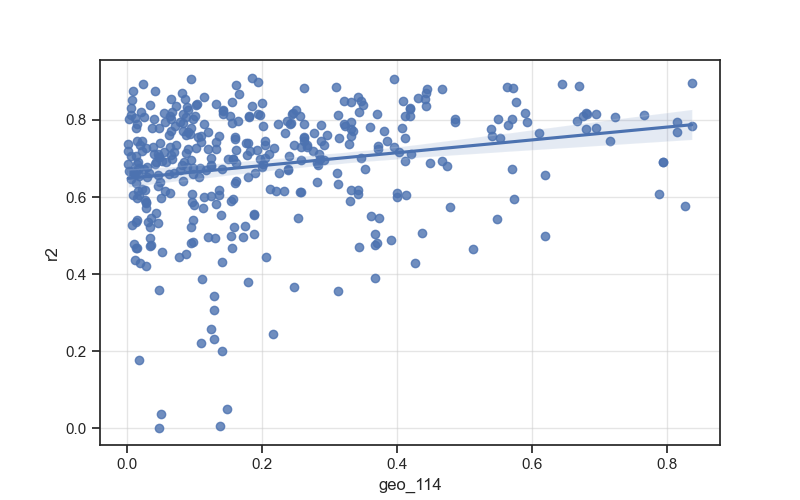

In [349]:
col='geo_114'
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x=col, y="r2", data=gw_sel[gw_sel[col]>0].sort_values(by=col), fit_reg=True)
plt.grid(alpha=0.5)

## 9. Intersection with long-term recharge

In [351]:
sns.set_theme(style="ticks")
recharge=rasterio.open("D:/Data/students/mariana/data/Raster/gw_long_term_recharge/bgr/data/GWN1000__3034_v1_raster1_4647.tif")

In [352]:
cl="recharge"
coord_list = [(x,y) for x,y in zip(gw_sel['geometry'].x , gw_sel['geometry'].y)]
gw_sel[cl] = [x[0] for x in recharge.sample(coord_list)]

<IPython.core.display.Javascript object>


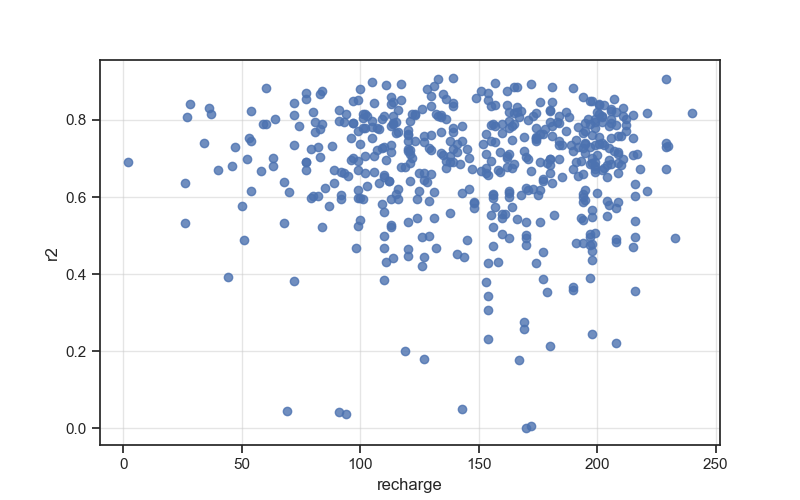

In [353]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x=cl, y="r2", data=gw_sel[gw_sel[cl]<900].sort_values(by=cl), fit_reg=False)
plt.grid(alpha=0.5)

### 9.1 Long term recharge with Buffer

In [354]:
gw_sel['buff_2km']=gw_sel.buffer(2000)

In [355]:
gw_sel['recharge_buff']=np.zeros(len(gw_sel))
for i in range(len(gw_sel)):
    out_mask, out_transform = rasterio.mask.mask(recharge, gw_sel['buff_4km'][i:i+1], crop=True)
    meanval=np.mean(out_mask[out_mask!=recharge.meta['nodata']])
    gw_sel['recharge_buff'][i]=meanval
    

<IPython.core.display.Javascript object>


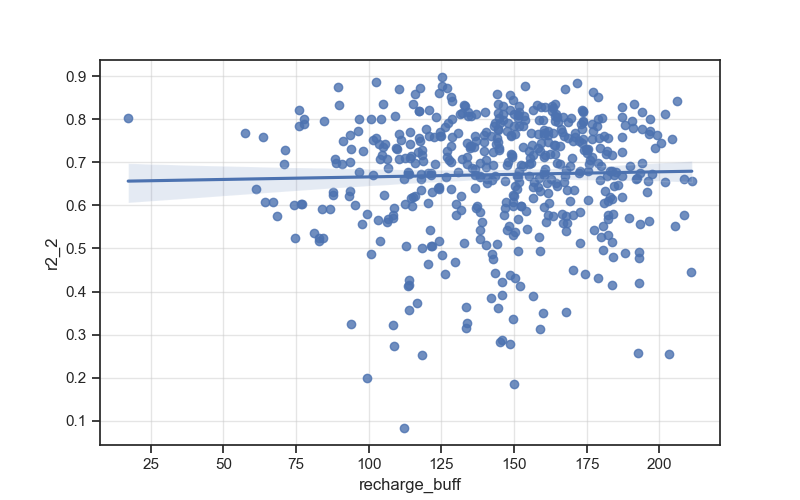

In [356]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x='recharge_buff', y="r2_2", data=gw_sel.sort_values(by=['recharge_buff']), fit_reg=True)
plt.grid(alpha=0.5)

In [427]:
#Remove uncompatible columns
l=list(gw_sel.columns)
for i in range(1,6):
    l.remove('buff_'+str(i)+'km')

In [428]:
#Save the information excluding the buffer columns
gw_sel[l].to_file('D:/Data/students/mariana/data/SHP/gw_sel_int.shp')  